<a href="https://colab.research.google.com/github/jaejoonk/DR6_Notebooks/blob/main/ACT_DR6_lensing_galaxy_cross_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 5: Lensing Maps

We use ACT Data Release 6 (DR6) reconstructed lensing mass maps (and are publicly available on NASA LAMBDA) to demonstrate a cross-correlation with CMASS galaxies.

Notebook Info | Value
---|---
Dependencies | `numpy`, `scipy`, `healpy`, `matplotlib`, `pixell`
Data products | "act_planck_dr4.01_s14s15_D56_lensing_kappa_baseline.fits"
| "galaxy_DR12v5_CMASSLOWZTOT_South.fits"
|"act_dr4.01_s14s15_D56_lensing_mask.fits"
Memory usage | Medium (~ a few GB)
Contributors | Maya Mallaby-Kay, Zach Atkins

To return to the main notebook or to view a different section use the links in the table of contents.


## Table of contents

 ---
> [Section 1](Section_1_Introduction.ipynb): Introduction to ACT Data Release 4

> [Section 2](Section_2_coadded_maps.ipynb): S08-16 Coadded maps from [Naess et al (2020)](https://phy-act1.princeton.edu/public/saiola/act_dr4_N20.pdf) and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to convert maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  The DR5 Cluster Catalog from [Hilton et al (2020)](https://arxiv.org/abs/2009.11043) and Visualizing Objects in the Maps

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps from [Darwish et al (2020)](https://arxiv.org/pdf/2004.01139.pdf)

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps from [Madhavacheril et al (2019)](https://arxiv.org/abs/1911.05717)

> [Section 7](Section_7_power_spectra_part_1.ipynb): Power Spectra Part 1 - Harmonic Analysis using CAR maps [Naess et al (2020)](https://phy-act1.princeton.edu/public/saiola/act_dr4_N20.pdf)

> [Section 8](Section_8_power_spectra_part_2.ipynb) Power Spectra Part 2 - Power Spectrum example using Nawrapper [Aiola et al (2020)](https://phy-act1.princeton.edu/public/saiola/act_dr4_A20.pdf) and [Choi et al (2020)](https://phy-act1.princeton.edu/public/saiola/act_dr4_C20.pdf)

> [Section 9](Section_9_Noise_sims.ipynb): Generating Noise Simulations

> [Section 10](Section_10_E_B_maps.ipynb):  Look at how to generate E and B maps from I, Q, U maps.

> [Section 11](Section_11_ACT_likelihood.ipynb): Using the ACT Likelihood code

> [Section 12](Section_12_delensing_param_shifts.ipynb):  Delensing the CMB powerspectrum and comparing the delensed and lensed parameters from [Han et al. (2020)](https://arxiv.org/pdf/2007.14405.pdf)

---

## Initialize notebook

We begin by installing key dependencies and software that we will use in this notebook.

We will also define a function `eshow` that plots CAR / rectangular `pixell` maps for us.

In [32]:
!pip install numpy matplotlib pixell astropy healpy

In [40]:
import pixell
from pixell import enplot, enmap, reproject, curvedsky as cs
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

def eshow(x,**kwargs):
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [ ]:
# !wget https://portal.nersc.gov/project/act/dr6_lensing_v1/maps/baseline/kappa_alm_data_act_dr6_lensing_v1_baseline.fits
!wget https://portal.nersc.gov/project/act/dr6_lensing_v1/maps/baseline/mask_act_dr6_lensing_v1_healpix_nside_4096_baseline.fits

--2024-07-19 16:08:55--  https://portal.nersc.gov/project/act/dr6_lensing_v1/maps/baseline/mask_act_dr6_lensing_v1_healpix_nside_4096_baseline.fits
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.106
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610619840 (1.5G) [image/fits]
Saving to: ‘mask_act_dr6_lensing_v1_healpix_nside_4096_baseline.fits’

mask_act_dr6_lensin 100%[===================>]   1.50G  44.4MB/s    in 36s     

2024-07-19 16:09:31 (42.9 MB/s) - ‘mask_act_dr6_lensing_v1_healpix_nside_4096_baseline.fits’ saved [1610619840/1610619840]



In [34]:
lensing_alms = hp.read_alm("kappa_alm_data_act_dr6_lensing_v1_baseline.fits").astype(np.complex128)
lensing_alms[~np.isfinite(lensing_alms)] = 0.

fullsky_shape, fullsky_wcs = enmap.fullsky_geometry(res=np.deg2rad(4.0/60.))
lensing_mask_healpix = hp.read_map("mask_act_dr6_lensing_v1_healpix_nside_4096_baseline.fits")
# downgrade to save some time
lensing_mask_healpix = hp.ud_grade(lensing_mask_healpix, 1024)
lensing_mask = reproject.healpix2map(lensing_mask_healpix, fullsky_shape, fullsky_wcs)

# compute both healpix and pixell versions of my maps
lensing = cs.alm2map(lensing_alms, enmap.empty(fullsky_shape, fullsky_wcs))
lensing_healpix = hp.alm2map(lensing_alms, nside=1024)

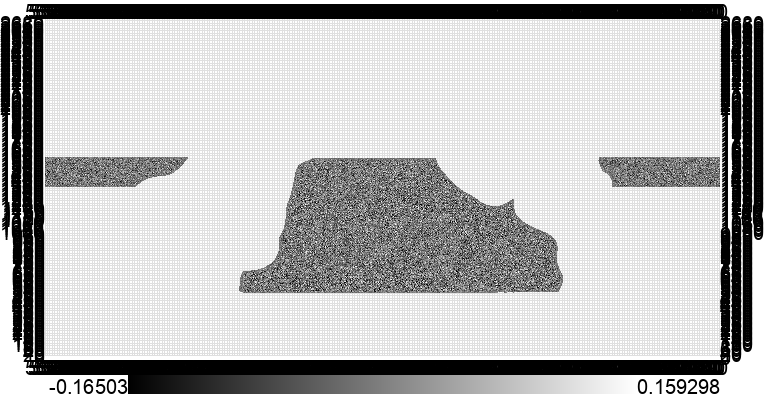

In [19]:
# hide zero pixels to highlight our analysis footprint
lensing_visual = np.copy(lensing)
lensing_visual[lensing_mask < 0.3] = np.nan
# Plot the map
eshow(lensing_visual, **{"downgrade": 8, "ticks": 20, "colorbar": True, "color": 'gray'})

## Cross correlate with a galaxy over density map

These lensing maps can be cross correlated with other maps either directly in Pixell or by reprojecting to HEALPix.  For this demonstration we will cross correlate the lensing map with a galaxy overdensity map.  Since HEALPix is based on equal area pixels it is somewhat easier to build a density map in HEALPix.  In order to then cross correlate with the lensing map we will project the above CAR map to HEALPix as described in the Section 3 notebook.

Once we've reprojected the map we can build a galaxy overdensity map using the definition
\begin{align}
g(\hat{p}) = \frac{n(\hat{p}) - \bar{n}}{\bar{n}}
 \tag{1}
\end{align}

Where $n(\hat{p})$ is the number of galaxies in pixel $\hat{p}$, and $\bar{n}$ is the mean number of galaxies.

This process is based on a notebook produced by Mathew Madhavacheril that is available [here](https://github.com/ACTCollaboration/Season2LensingMaps/blob/master/LensingXCorr.ipynb)

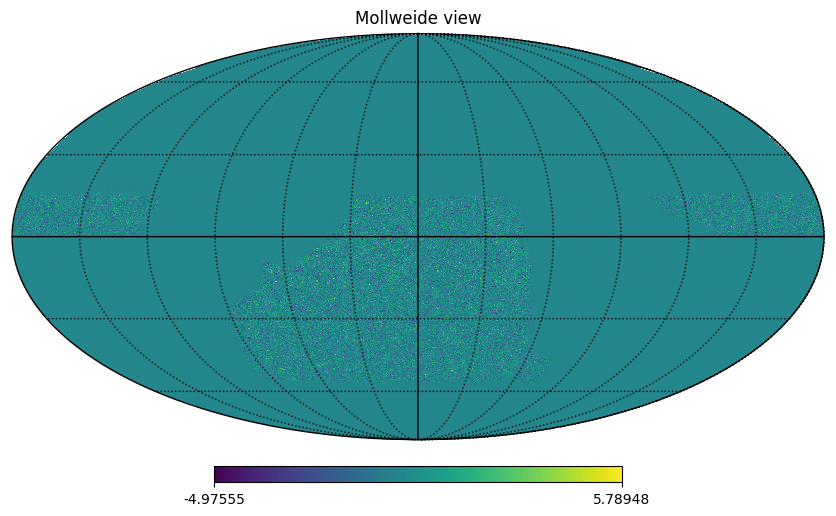

In [20]:
# Project the lensing map to HEALPix
lensing_hp = hp.alm2map(lensing_alms.astype(np.complex128), nside=1024)
hp.mollview(lensing_hp)
hp.graticule()

## Make the overdensity map

To begin with we will read in a catalog of galaxies.  This can be found [here](https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz) from SDSS' BOSS catalog of CMASS galaxies.  

In [ ]:
!wget https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz
!gunzip galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz

--2024-07-19 16:28:05--  https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz
Resolving data.sdss.org (data.sdss.org)... 155.101.19.133
Connecting to data.sdss.org (data.sdss.org)|155.101.19.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83199463 (79M) [application/octet-stream]
Saving to: ‘galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz’

galaxy_DR12v5_CMASS 100%[===================>]  79.34M  40.7MB/s    in 1.9s    

2024-07-19 16:28:07 (40.7 MB/s) - ‘galaxy_DR12v5_CMASSLOWZTOT_South.fits.gz’ saved [83199463/83199463]



In [21]:
from astropy.io import fits
from astropy import units as u
redmap_hdu = fits.open("galaxy_DR12v5_CMASSLOWZTOT_South.fits")

class galaxy_catalog:
    def __init__(self, catalog):
        self.RA  = catalog[1].data['RA'] *u.deg
        self.DEC = catalog[1].data['DEC']*u.deg

redmap = galaxy_catalog(redmap_hdu)

### Generating an over density map using the catalog

Now that we have the catalog we can generate an over density map by first creating a HEALPix map with the same shape and size as the lensed map, but filled with zeros.  From there we can find the pixel location of each galaxy and add the galaxies to our empty map.  



In [22]:
nside = 1024
class CatMapper():
    def __init__(self,ras_deg,decs_deg, weights = None):
            self.nside = nside
            self.shape = hp.nside2npix(nside)
            self.pixs = hp.ang2pix(nside,ras_deg,decs_deg,lonlat=True)
            self.counts = self.get_map(weights=weights)

    def get_map(self,weights=None):
        return np.histogram(self.pixs,bins=self.shape,weights=weights,
                            range=[0,self.shape],density=False)[0].astype(np.float32)

galaxies = CatMapper(redmap.RA.value, redmap.DEC.value).get_map()


Next we apply a mask to the map and then finish by subtracting the mean from each pixel and dividing by the mean as indicated by equation 1 above. In this case we load the SDSS CMASS South mask to use for our galaxy density map.

In [24]:
!wget https://github.com/jaejoonk/DR6_Notebooks/raw/main/mask_CMASS_DR12_nside1024_S_comp1_vetos1_resfac6_v2.fits

--2024-07-19 17:02:12--  https://github.com/jaejoonk/DR6_Notebooks/raw/main/mask_CMASS_DR12_nside1024_S_comp1_vetos1_resfac6_v2.fits
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jaejoonk/DR6_Notebooks/main/mask_CMASS_DR12_nside1024_S_comp1_vetos1_resfac6_v2.fits [following]
--2024-07-19 17:02:13--  https://raw.githubusercontent.com/jaejoonk/DR6_Notebooks/main/mask_CMASS_DR12_nside1024_S_comp1_vetos1_resfac6_v2.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50339520 (48M) [application/octet-stream]
Saving to: ‘mask_CMASS_DR12_nside1024_S_comp1_vetos1_resfac6_v2.fits’

mask_CMASS_DR12_nsi

<ipython-input-35-fb993e665398>:20: RuntimeWarning: divide by zero encountered in divide
  galaxy_map_healpix[unmasked] = (galaxies[unmasked] - mean) / mean
<ipython-input-35-fb993e665398>:20: RuntimeWarning: invalid value encountered in divide
  galaxy_map_healpix[unmasked] = (galaxies[unmasked] - mean) / mean


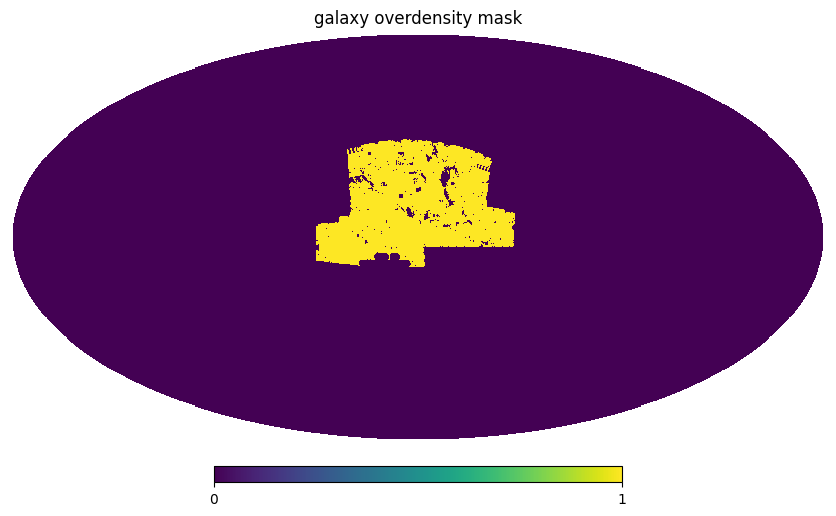

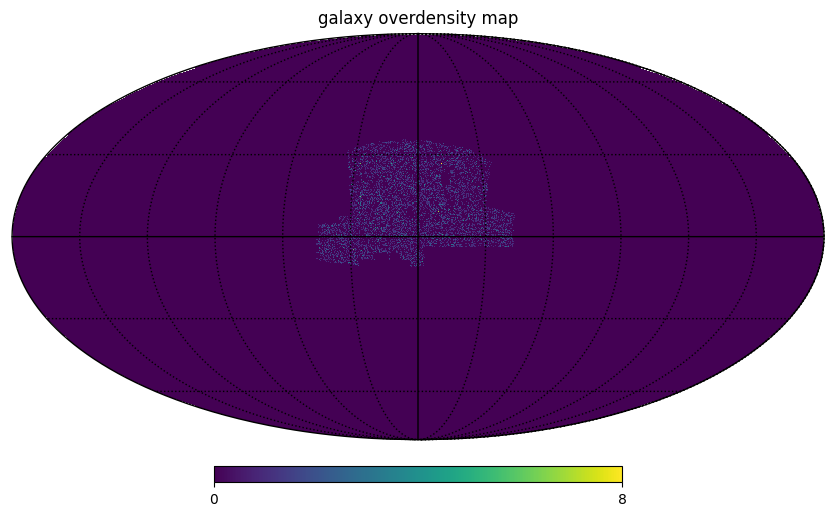

In [35]:
# Load the mask
galaxy_mask_healpix = hp.read_map("mask_CMASS_DR12_nside1024_S_comp1_vetos1_resfac6_v2.fits")
# make it binary
galaxy_mask_healpix[galaxy_mask_healpix <= 0.3] = 0.
galaxy_mask_healpix[galaxy_mask_healpix > 0.3] = 1.
hp.mollview(galaxy_mask_healpix, title="galaxy overdensity mask")

galaxy_mask = reproject.healpix2map(galaxy_mask_healpix, fullsky_shape, fullsky_wcs)

# We now select the pixels that are masked and unmasked
masked = np.where(galaxy_mask <= 0.3)[0]
unmasked = np.where(galaxy_mask > 0.3)[0]

# Calculate the mean needed for equation 1
mean = galaxies[unmasked].mean()

# Create the map
galaxy_map_healpix = galaxies.copy()
galaxy_map_healpix[masked] = 0.
galaxy_map_healpix[unmasked] = (galaxies[unmasked] - mean) / mean
# avoid nans
galaxy_map_healpix[~np.isfinite(galaxy_map_healpix)] = 0.

# Plot the map
hp.mollview(galaxy_map_healpix, title="galaxy overdensity map")
hp.graticule()

### Cross-correlate

Now that since we are able to visualize the lensed map as well as the galaxy map we can cross-correlate them. For now we note that this is done by apodizing the maps and then using a Fourier transform approach to calculate the cross spectrum between the two maps.

We also need to take into account the mask that has been applied to the maps.  Ordinarily one can correct for the effects of masking using
$$C_L \rightarrow \frac{C_L}{\langle W\rangle} $$
However the lensing maps already have a window / mask $W_L$ applied to them before the reconstruction takes place and so to correctly account for this effect we approximate by treating the effectively applied mask as $W_L^2$.

We will also need to correct for the galaxy map's window / mask, and that is done by computing an overall correction factor of $\langle W_L^2 W_g\rangle$.

In [37]:
W_L = lensing_mask_healpix
W_g = galaxy_mask_healpix

# Calculate the new window correction
wfactor = np.mean(W_g*W_L**2)

### Cross-correlate the maps

Now that we have both the correct masks effectively applied and the mask correction factor we can begin to cross correlate the two maps.  Since we have two HEALPix maps we can follow the usual cross-correlation procedures and use anafast to get $C_\ell$.  This is actually slightly different to the method using in [Darwish et al (2020)](https://arxiv.org/pdf/2004.01139.pdf).  Those results are based on Fourier transforms in Pixell, however, we choose to present a Healpix based example so that users who are more familiar with Healpix can easily follow our approach.

In [43]:
# Use anafast to generate cls

cl  = hp.anafast(galaxy_map_healpix, lensing_healpix) / wfactor
ell = np.arange(len(cl))
print(ell.max())
# Bin the resulting spectra as well as the ell values
bins      = np.linspace(50, 3000, 30)
digitized = np.digitize(ell, bins)
cl_binned  = [cl[digitized == i].mean() for i in range(1, len(bins))]
ell_binned = [ell[digitized == i].mean() for i in range(1, len(bins))]

3071


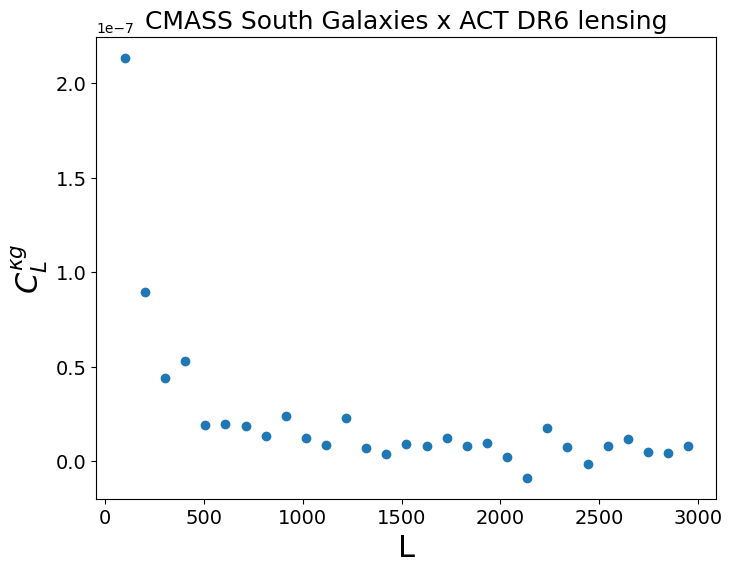

In [44]:
# Now plot the quick power spectrum we just made
plt.figure(figsize = (8,6))
#plt.rc('font', family='serif')
plt.plot(ell_binned,cl_binned,marker="o",ls="none")
plt.xlabel('L', fontsize = 22)
plt.ylabel('$C_{L}^{\kappa g}$', fontsize = 22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("CMASS South Galaxies x ACT DR6 lensing", fontsize=18)
#plt.grid(True)
plt.show()

We definitely see a signal here that tapers off and approaches zero for higher L values but is above zero for low L, which is exactly what we expect to see.  We notice some fluctuations and of course we recognize that this quick cross correlation has only been done and does not take into account systematics such as:

- Shot noise treatment (Poissonian noise from placing galaxies on pixelized map)
- Pixel window function (Power spectrum from a discrete pixelized grid can be biased compared to a smooth map)
- Mode coupling (Potentially complex mask geometries induce coupling between modes)
- Transfer function ($W_L^2$ approximation is not exact, can calibrate multiplicative biases with simulations)

and many, many more details that go into utilizing these cross-correlation power spectra to properly infer cosmology.


A few of many examples of these CMB lensing x galaxy overdensity cross-correlation analyses that involve (now) public ACT data:
- [Marques et al. 2024](https://arxiv.org/abs/2306.17268) :)
- [Kim et al. 2024](https://arxiv.org/abs/2407.04606) / [Sailer et al. 2024](https://arxiv.org/abs/2407.04607) :)
- [Farren et al. 2023](https://arxiv.org/abs/2309.05659)

